In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ssl
import nltk
import spacy
import warnings
import contractions
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
warnings.filterwarnings('ignore')

In [2]:
sentiment_df=pd.read_csv("../data/sentiment_train",delimiter="\t")

In [3]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7086 entries, 0 to 7085
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  7086 non-null   int64 
 1   text       7086 non-null   object
dtypes: int64(1), object(1)
memory usage: 110.8+ KB


In [4]:
sentiment_df.head(5)

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [5]:
sentiment_df.describe(include='all')

,sentiment,text
count,7086.000000,7086
unique,NaN,1410
top,NaN,I love Harry Potter.
freq,NaN,167
mean,0.563788,NaN
std,0.495949,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN


<h1><span style="color:red"> Step1:- EDA </span> </h1>(Preporcessing and Visualization)<br>Remove numbers ,space and non word characters from beginning of each text.

<h3><span style="color: blue;"> Text Preprocessing steps-></span></h3>
<ol>
<li>Convert Text to Lowercase</li>
<li>Remove Duplicate and Null Values</li>
<li>Remove special characters, punctuation and unwanted symbols</li>
<li>Handling Numbers</li>
<li>Handling Emoticon</li>
<li>Remove URLs and HTML tags</li>
<li>Handling Contraction (Use it cautiously) </li>
<li>Spell Correction</li>
<li>Tokenization</li>
<li>Remove Stop words</li>
<li>Stemming or Lemmatization</li>
</ol>

In [6]:
sentiment_df["text"] = sentiment_df["text"].str.lower() #1

#1 When we want to preserve capitalization of named entities 

In [7]:
unique_sentiments=sentiment_df['sentiment'].unique()
for sentiment in unique_sentiments:
    print(sentiment)

1
0


In [8]:
sentiment_df_preprocessed=sentiment_df.drop_duplicates().dropna() #2

In [9]:
sentiment_df_preprocessed.shape[0]

1351

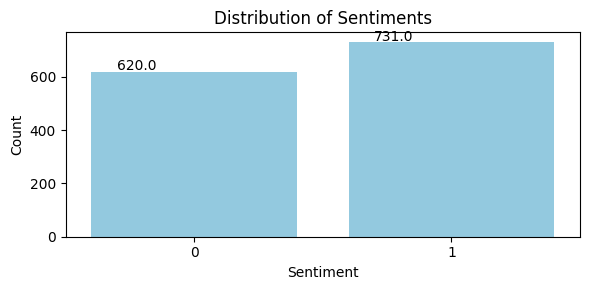

In [10]:
plt.figure(figsize=(6,3))
ax=sns.countplot(x='sentiment',data=sentiment_df_preprocessed, color='skyblue');
for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x()+0.1,p.get_height()+5))
#ax.set_xticklabels(['Negative','Positive'], rotation=0)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.tight_layout()
plt.show()    

from count plot we can see though they are not perfectly balanced we can call them well balaced sentiments so we will not do anything with balancing the data.

In [11]:
def remove_special_characters_and_numbers(text): #3, 4
    stripped_text = text.strip()
    # Replace special characters with "special_character" except "&" with "and"
    converted_text1 = stripped_text.replace('&', 'and')
    # Keep only words, space and apostrophe
    converted_text2 = re.sub(r'[^a-z\s\']', '', converted_text1)
    # Remove multiple consecutive spaces and keep only one
    converted_text3 = re.sub(r'\s+', ' ', converted_text2)
    return converted_text3

def remove_emoticons(text): #5
    # Define a regular expression pattern to match emoticons
    emoticon_pattern = re.compile(u'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', flags=re.UNICODE)
    text_without_emoticon = re.sub(emoticon_pattern, '', text)
    return text_without_emoticon

def remove_urls(text): #6.1
    return re.sub(r'http\S+', '', text)

def remove_html_tags(text): #6.2
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Apply above + contraction preprocessing steps #7
sentiment_df_preprocessed['processed_text1'] = sentiment_df_preprocessed['text'].apply(
    remove_special_characters_and_numbers).apply(remove_emoticons).apply(remove_urls).apply(remove_html_tags)

#.apply(contractions.fix)

<h2><span style="color: red;">NOTE:</span></h2>In NLP, handling contraction is not typical practice as they carry semantic meaning and set the tone of the text so it is essential to preserve them as they contribute to the overall meaning of the text. Removing contractions as stop words might inadvertently alter the intended meaning of the text. Here I did it for testing purpose, it didnot work well so removed it.

In [12]:
sentiment_df_preprocessed.dropna(subset=['text'],inplace=True)

8# Spelling Correction

<h4><span style="color: brown;"> which Library to choose?</span></h4>
<ul>
<li>For general-purpose, easy-to-use spell checking: TextBlob</li>
<li>For flexibility and customization: nltk.edit_distance</li>
<li>For speed and efficiency: spellchecker</li>
<li>For simple integration within Python: spellchecker from autocorrect</li>
</ul>

In [13]:
#8- If the training dataset is huge then we can skip this process
spell_checker=SpellChecker()

def correct_spelling(text):
    corrected_text=[]
    words=text.split()
    for word in words:
        corrected_word=word if word =='vinci' else spell_checker.correction(word)
        corrected_word=word if corrected_word is None else corrected_word
        corrected_text.append(corrected_word)
    return ' '.join(corrected_text)

%time sentiment_df_preprocessed['processed_text2'] = sentiment_df_preprocessed['processed_text1'].\
apply(correct_spelling)

CPU times: user 2min 51s, sys: 116 ms, total: 2min 51s
Wall time: 2min 52s


Now handle stop words ( common words like "the", "is", "and" etc. )

In [14]:
#Stemming was incorrectly converting words so commented out that part

In [15]:
#9, 10, 11
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    manually_added_stopwords={'vinci','brokeback','harry','potter','mission','code'}
    stop_words = set(stopwords.words('english'))
    stop_words.update(manually_added_stopwords)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Stemming
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(lemmatized_tokens)

sentiment_df_preprocessed['processed_text3'] = sentiment_df_preprocessed['processed_text2'].apply(preprocess_text)

<h1><span style="color:red"> Step2:- Train-Test-Split </span> </h1> <h3> 

In [16]:
X=sentiment_df_preprocessed['processed_text3']
y=sentiment_df_preprocessed['sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

<h1><span style="color:red"> Step3:- Vectorization </span> </h1> <h3> The first step creating BoW is to create a dictionary of all words used in the corpus.</h3> In this step we will not worry about grammar and only occurrence of the word is captured.

Convert each document to a vector that represents words available in the document. There are three ways to do that<br> <ol><li><b><span style="color:blue">Count Vector Model-></span></b> count the occurrence of each word in the document.</li><li><b><span style="color:blue">Term Frequency Vector Model-></span></b> the frequency of each word(term) in the document. that means number of occurrences of that word divided by total number of words</li><li><b><span style="color:blue">Term Frequency-Inverse DocumentFrequency (TF-IDF) Model-></span></b> Shows the importance of a word to a document. It increases proportionally to the number of times a word apprears in the document and is reduced by the frequency of the word present in the corpus. </li></ol>

In [17]:
countVectorizer=CountVectorizer()
bow_sparse_vector=countVectorizer.fit_transform(X_train) 
features=countVectorizer.get_feature_names_out()

In [18]:
bow_sparse_vector.shape

(1080, 1553)

In [19]:
bow_sparse_vector.getnnz() #To count the total non zero elements in the sparse matrix

5287

In [20]:
bow_dense_vector_df=pd.DataFrame(bow_sparse_vector.todense())
bow_dense_vector_df.columns=features

In [21]:
bow_dense_vector_df

,able,abortion,absolute,absolutely,absurd,academy,acceptable,accompaniment,according,account,...,yahoo,yea,yeah,year,yes,yesterday,yet,young,younger,yuck
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets try to analyze frequency of features using histogram

In [22]:
feature_counts=bow_dense_vector_df.sum(axis=0).to_frame().sort_values(by=0,ascending=False)
len(feature_counts[feature_counts[0]>1])

521

👆 We can see only 562 tokens has more than one entry so we will go back to line number 17 and add this condition

🦋 We can also check token level sentiment by by Sentiment Lexicon or Token-Level Sentiment Association: To do Token-Level Sentiment Association we can associate sentiment labels or scores with individual tokens in our documents based on the sentiment of the overall document or sentence. For example, if a document is classified as positive, we can consider all tokens in that document as having positive sentiment. But this can give misleading result so we will skip this part.

# visualization of count vector

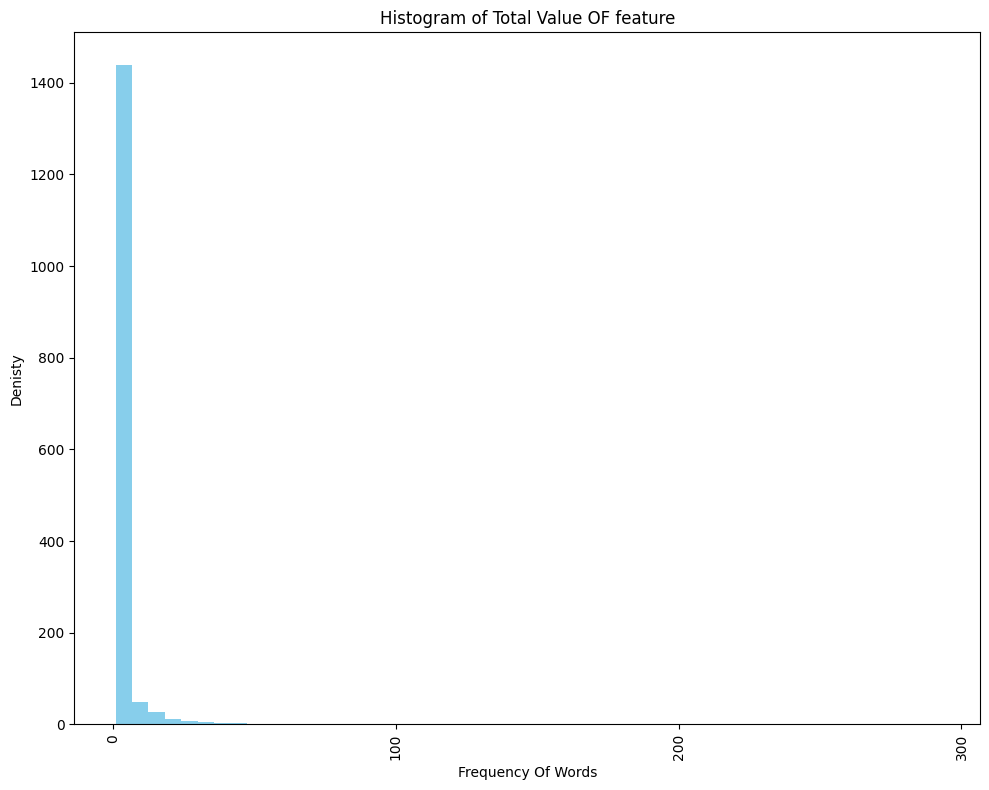

In [23]:
feature_sums=bow_dense_vector_df.sum(axis=0)
bin_edges=np.arange(0,feature_sums.max()+100,100)

plt.figure(figsize=(10,8))
plt.hist(feature_sums, bins=50, color='skyblue')
plt.xlabel("Frequency Of Words")
plt.ylabel("Denisty")
plt.title('Histogram of Total Value OF feature')
plt.xticks(bin_edges,rotation=90)  # Rotated x-axis labels for better readability
plt.tight_layout()
plt.show()

We can see most features have very rare occurrences (bin 0-50), now lets see how they are distributed

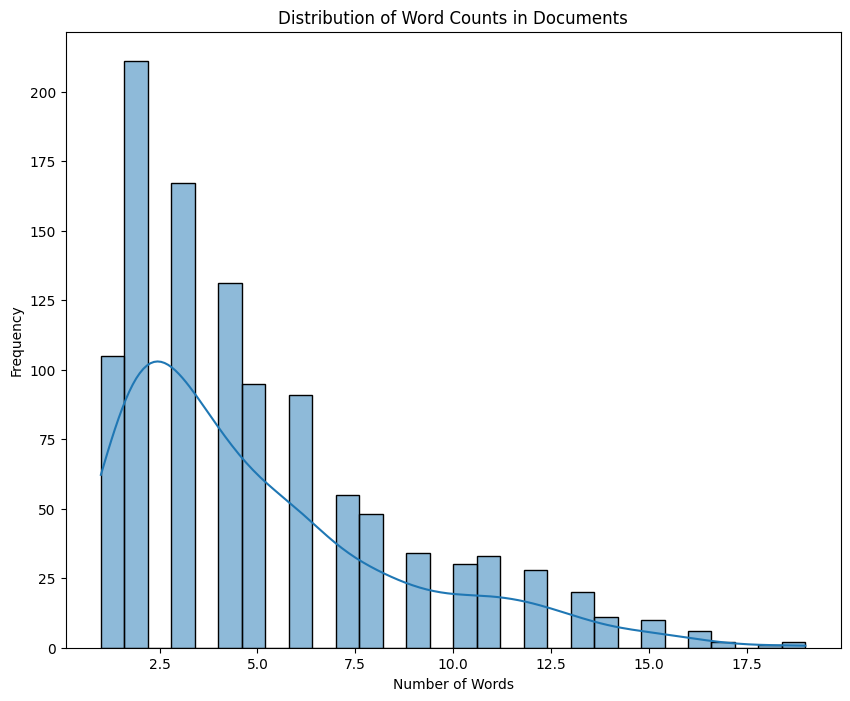

In [24]:
word_counts = bow_sparse_vector.sum(axis=1)
plt.figure(figsize=(10,8))
sns.histplot(word_counts, bins=30, kde=True, legend=False)
plt.title('Distribution of Word Counts in Documents')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

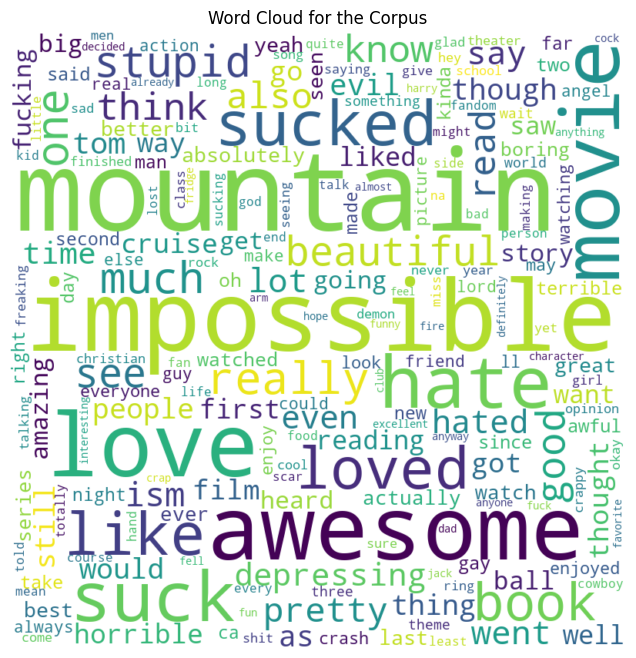

In [25]:
# Visualize word cloud for the most common words in the corpus
word_frequencies = dict(zip(features, bow_sparse_vector.sum(axis=0).tolist()[0]))
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_frequencies)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for the Corpus')
plt.axis('off')
plt.show()

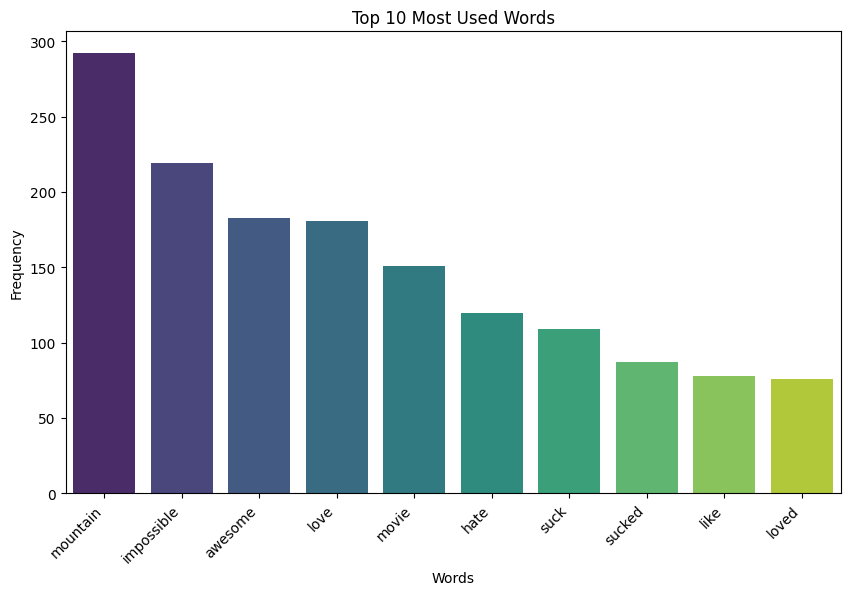

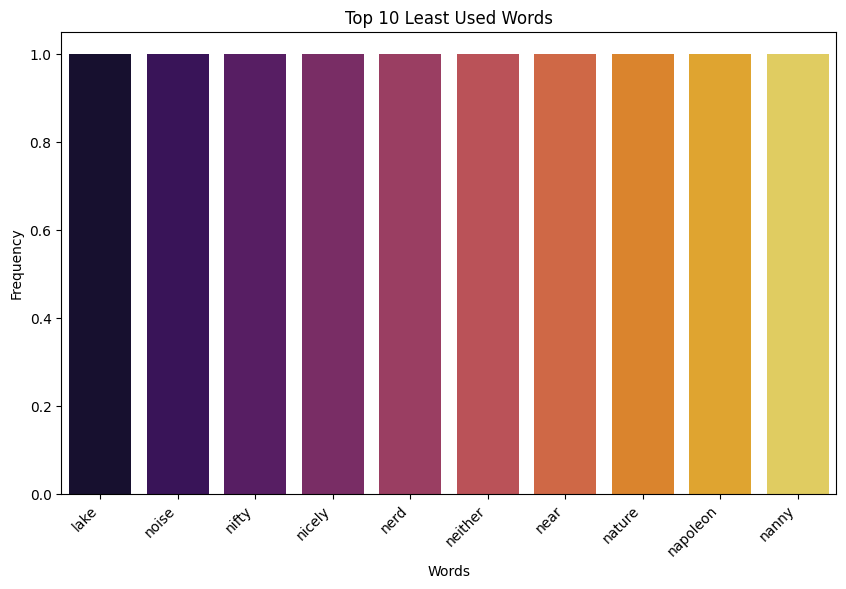

In [26]:
word_frequencies = np.array(bow_sparse_vector.sum(axis=0)).reshape(-1)

top_indices = np.argsort(-word_frequencies)[:10]
bottom_indices = np.argsort(word_frequencies)[:10]

# Extract the top 10 most and least frequent words
top_words = [features[idx] for idx in top_indices]
bottom_words = [features[idx] for idx in bottom_indices]

# Plot the top words
plt.figure(figsize=(10, 6))
sns.barplot(x=top_words, y=word_frequencies[top_indices], palette="viridis")
plt.title('Top 10 Most Used Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the least used words
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_words, y=word_frequencies[bottom_indices], palette="inferno")
plt.title('Top 10 Least Used Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Observation:- We can see all movie names are most frequented words but we know they do not show any sentiment we need to find words which shows sentiment about these movies. so we will manually add these words in our stop word list in line number 15 ( ln[15] )

<h1><span style="color:red"> Step4:- Model Building </span> </h1> <h3>Training and Evaluation

In [27]:
bow_dense_vector_df.shape,y_train.shape

((1080, 1553), (1080,))

In [28]:
bow_sparse_vector.shape,y_train.shape

((1080, 1553), (1080,))

In [29]:
X_train_vec=bow_sparse_vector
X_test_vec=countVectorizer.transform(X_test)

Let’s try some simple models and use cross-validation to determine which one works best.

In [30]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest',RandomForestClassifier()),
    ('Naive Bayes', MultinomialNB()),
    ('Support Vector Machine', SVC())
         ]
for name, model in models:
    scores= cross_val_score(model, X_train_vec,y_train,cv=5,scoring='accuracy')
    print(f"{name} - Mean Accuracy: {scores.mean()}, Std: {scores.std()}")

Logistic Regression - Mean Accuracy: 0.9648148148148149, Std: 0.015382636783181603
Random Forest - Mean Accuracy: 0.95, Std: 0.013857990321384949
Naive Bayes - Mean Accuracy: 0.962037037037037, Std: 0.013545128554007226
Support Vector Machine - Mean Accuracy: 0.9537037037037038, Std: 0.012072597046671556


Looks like Logistic Regression performing best

In [31]:
chosen_model=LogisticRegression()
model.fit(X_train_vec,y_train)
y_pred=model.predict(X_test_vec)
accuracy=accuracy_score(y_test,y_pred)
print(f"accuracy: {accuracy}")
print(f"classification report:-")
print(classification_report(y_test,y_pred))

accuracy: 0.974169741697417
classification report:-
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       123
           1       0.97      0.98      0.98       148

    accuracy                           0.97       271
   macro avg       0.97      0.97      0.97       271
weighted avg       0.97      0.97      0.97       271



We achieved a 97.4% accuracy with default parameters. Can we improve it by selecting the best Logistic Regression parameters? Let’s find out using Grid Search CV.

In [32]:
param_grid = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'penalty': ['l1', 'l2'],      # Penalty norm
    'solver': ['liblinear']       # Solver for optimization
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=chosen_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_vec, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the mean cross-validated score of the best_estimator_
print("Best Mean Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Mean Accuracy: 0.9657407407407407


In [33]:
chosen_model=LogisticRegression(**grid_search.best_params_)
model.fit(X_train_vec,y_train)
y_pred=model.predict(X_test_vec)
accuracy=accuracy_score(y_test,y_pred)
print(f"accuracy: {accuracy}")
print(f"classification report:-")
print(classification_report(y_test,y_pred))

accuracy: 0.974169741697417
classification report:-
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       123
           1       0.97      0.98      0.98       148

    accuracy                           0.97       271
   macro avg       0.97      0.97      0.97       271
weighted avg       0.97      0.97      0.97       271



<h1><span style="color:green">Final Verdict:-</span></h1>It seems there’s no improvement. Therefore, our final model maintains a 97.4% accuracy. We’ll explore additional preprocessing steps later to see if our model improves